In [12]:
import pandas as pd
import numpy as np
import yfinance as yf
from matplotlib import pyplot as plt

### Gathering Data for Pricing Brent Oil Futures
We are gathering US Brent Crude Oil Futures

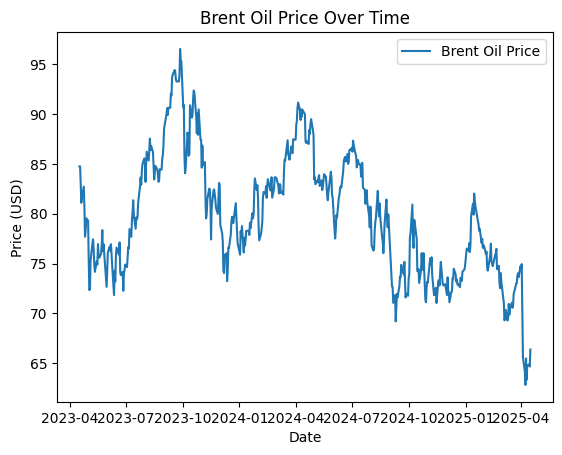

In [13]:
brent_oil = yf.Ticker("BZ=F")
brent_oil_data = brent_oil.history(period="2y", interval="1d")
brent_oil_data['Log Returns'] = np.log(brent_oil_data['Close'] / brent_oil_data['Close'].shift(1))
df = pd.DataFrame(brent_oil_data['Close'],brent_oil_data['Log Returns'])
plt.plot(brent_oil_data.index, brent_oil_data['Close'], label='Brent Oil Price')
plt.title('Brent Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

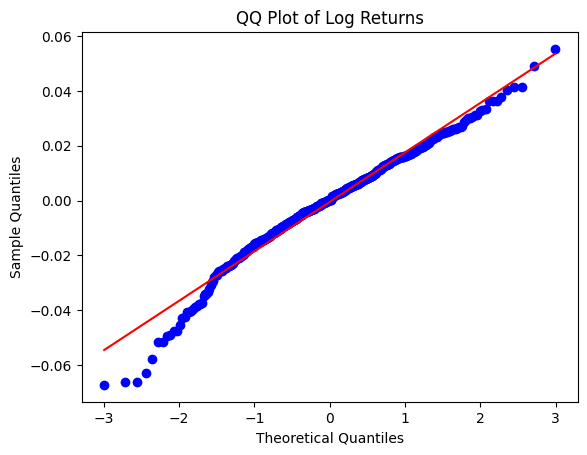

In [19]:
from scipy.stats import probplot
probplot(brent_oil_data['Log Returns'].dropna(), dist="norm", plot=plt)
plt.title('QQ Plot of Log Returns')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()


#### Calculating historical volatility

In [15]:
annualized_volatility = brent_oil_data['Log Returns'].std() * np.sqrt(252)
print(f"Annualized Volatility: {annualized_volatility:.2%}")

Annualized Volatility: 28.85%


### Pricing Functions

In [20]:
def prob_p(r_f, delta_t, sigma):
    u = np.exp(sigma * np.sqrt(delta_t))
    d = np.exp(-sigma * np.sqrt(delta_t))
    p = (np.exp(r_f * delta_t) - d) / (u - d)
    return p

### Asian Options using BAPM